# Explore Interpretability Methods for Computer Vision Models
There are a number of techniques which can be used to glean understanding from "black box" models. In this notebook, we explore the `alibi` library, which implements several techniques over multiple modes (text, tabular data, etc.). We will be focusing on interpretability for a single computer vision model using the Fashion MNIST dataset.

In [ ]:
!pip install alibi tensorflow==2.2.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, Activation 
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 

In [ ]:
!nvidia-smi

Mon Apr 26 15:45:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Datasets

We only get train and test sets from the loader, so we'll create a validation set out of the training set.

From the docstring for `.load_data`, the classes are as follows: 

0.	T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot


In [ ]:
(x_dev, y_dev), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_dev, y_dev, 
                                                      random_state=7699,
                                                      test_size=10_000)

del x_dev, y_dev

In [ ]:
print(f"{x_train.shape[0]:,} rows in training")
print(f"{x_valid.shape[0]:,} rows in validation")
print(f"{x_test.shape[0]:,} rows in test")

50,000 rows in training
10,000 rows in validation
10,000 rows in test


In [ ]:
label_map = {
  0:	'T-shirt/top',
  1:	'Trouser',
  2:	'Pullover',
  3:	'Dress',
  4:	'Coat',
  5:	'Sandal',
  6:	'Shirt',
  7:	'Sneaker',
  8:	'Bag',
  9:	'Ankle boot'
}

Let's examine a handful of examples.

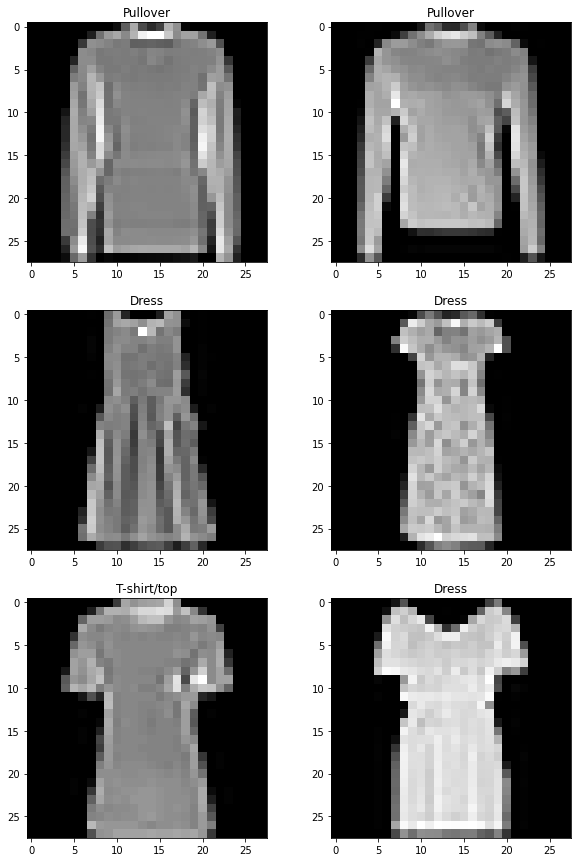

In [ ]:
ids = np.random.randint(0, x_train.shape[0], size=6)
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

current_row = 0
for i, id_ in enumerate(ids):
  example = x_train[id_]
  label = y_train[id_]
  title = label_map[label]
  current_col = i % 2
  ax[current_row][current_col].imshow(example, cmap='gray')
  ax[current_row][current_col].set_title(title)
  if (i+1) % 2 == 0:
    current_row += 1

plt.show()

In [ ]:
print(f"Unique classes: {', '.join(set(y_train.astype(str)))}")

# ensure the classes are all the same
assert set(y_train) == set(y_valid) == set(y_test)

Unique classes: 6, 5, 9, 2, 7, 3, 4, 0, 8, 1


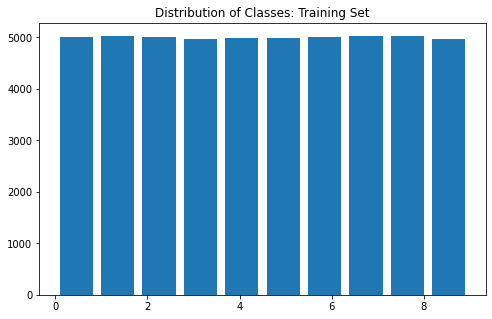

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(y_train, rwidth=0.8, bins=len(set(y_train)))
plt.title("Distribution of Classes: Training Set")
plt.show()

Prepare data for modeling

In [ ]:
def prep_data(x, y, set_name='', scale=True):
  x = x.astype('float32')
  if scale:
    x = x / 255.
  x = np.expand_dims(x, -1)
  print(f"x_{set_name} shape: {x.shape}")

  y = to_categorical(y)
  print(f"y_{set_name} shape: {y.shape}")
  
  return x, y

In [ ]:
x_train, y_train = prep_data(x_train, y_train, 'train')
print()
x_valid, y_valid = prep_data(x_valid, y_valid, 'valid')
print()
x_test, y_test = prep_data(x_test, y_test, 'test')

x_train shape: (50000, 28, 28, 1)
y_train shape: (50000, 10)

x_valid shape: (10000, 28, 28, 1)
y_valid shape: (10000, 10)

x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


## Build a Model

Feel free to skip ahead; we train a simple CNN with 2 convolutional layers using the Fashion MNIST data, reaching a validation accuracy of ~92% in 10 epochs.

In [ ]:
def model():
  x_in = Input(shape=(28,28,1), name = 'input')
  x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_1')(x_in)
  x = Activation('relu', name='relu_1')(x)
  x = MaxPooling2D(pool_size=2, name='maxp_1')(x)
  x = Dropout(0.3, name='drop_1')(x)

  x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_2')(x)
  x = Activation('relu', name='relu_2')(x)
  x = MaxPooling2D(pool_size=2, name='maxp_2')(x)
  x = Dropout(0.3, name='drop_2')(x)

  x = Flatten(name='flat')(x)
  x = Dense(256, name='dense_1')(x)
  x = Activation('relu', name='relu_3')(x)
  x = Dropout(0.5, name='drop_3')(x)
  x_out = Dense(10, name='dense_2')(x)
  x_out = Activation('softmax', name='softmax')(x_out)

  cnn = Model(inputs=x_in, outputs=x_out)
  cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return cnn 

In [ ]:
cnn = model()
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
relu_1 (Activation)          (None, 28, 28, 64)        0         
_________________________________________________________________
maxp_1 (MaxPooling2D)        (None, 14, 14, 64)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        16448     
_________________________________________________________________
relu_2 (Activation)          (None, 14, 14, 64)        0     

Train the model

In [ ]:
cnn.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=64, epochs=10)

Epoch 1/10
782/782 [==============================] - 8s 10ms/step - loss: 0.5820 - accuracy: 0.7880 - val_loss: 0.3689 - val_accuracy: 0.8640
Epoch 2/10
782/782 [==============================] - 7s 10ms/step - loss: 0.3971 - accuracy: 0.8561 - val_loss: 0.3102 - val_accuracy: 0.8854
Epoch 3/10
782/782 [==============================] - 7s 10ms/step - loss: 0.3542 - accuracy: 0.8705 - val_loss: 0.2836 - val_accuracy: 0.8952
Epoch 4/10
782/782 [==============================] - 7s 10ms/step - loss: 0.3249 - accuracy: 0.8820 - val_loss: 0.2737 - val_accuracy: 0.8995
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3044 - accuracy: 0.8887 - val_loss: 0.2627 - val_accuracy: 0.9055
Epoch 6/10
782/782 [==============================] - 7s 10ms/step - loss: 0.2892 - accuracy: 0.8936 - val_loss: 0.2479 - val_accuracy: 0.9105
Epoch 7/10
782/782 [==============================] - 7s 10ms/step - loss: 0.2712 - accuracy: 0.8995 - val_loss: 0.2428 - val_accuracy: 0.9150


Evaluate the model

In [ ]:
valid_pred = cnn.predict(x_valid)

In [ ]:
y_valid_names = pd.Series(y_valid.argmax(axis=1)).map(label_map).values
valid_pred_names = pd.Series(valid_pred.argmax(axis=1)).map(label_map).values

In [ ]:
print(classification_report(y_valid_names, valid_pred_names, digits=3))

              precision    recall  f1-score   support

  Ankle boot      0.989     0.929     0.958      1024
         Bag      0.982     0.981     0.981       982
        Coat      0.869     0.888     0.878      1012
       Dress      0.933     0.921     0.927      1032
    Pullover      0.864     0.907     0.885       988
      Sandal      0.989     0.964     0.976      1021
       Shirt      0.809     0.755     0.781       999
     Sneaker      0.905     0.991     0.946       972
 T-shirt/top      0.885     0.889     0.887       996
     Trouser      0.986     0.988     0.987       974

    accuracy                          0.921     10000
   macro avg      0.921     0.921     0.921     10000
weighted avg      0.921     0.921     0.920     10000



In [ ]:
import seaborn as sns

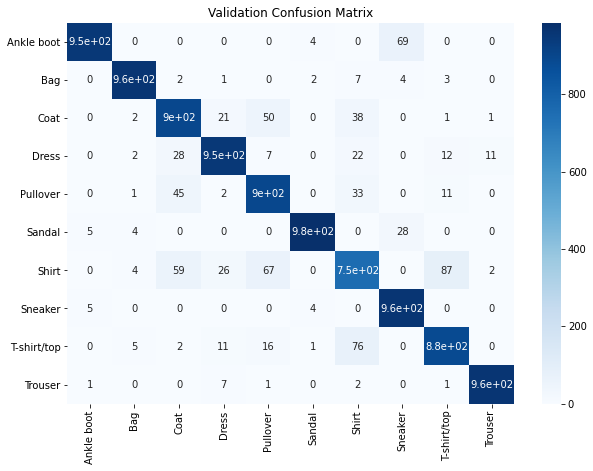

In [ ]:
valid_cm = confusion_matrix(y_valid_names, valid_pred_names)
valid_cm = pd.DataFrame(valid_cm, index=sorted(label_map.values()), 
                        columns=sorted(label_map.values()))
plt.figure(figsize=(10, 7))
sns.heatmap(valid_cm, annot=True, cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()

## Global Interpretability
`alibi` provides several methods of interpretability for computer vision models. We will use the model trained above to illustrate these methods, starting with those for global interpretability.

### Linearity of Each Layer
We can quantify the linearity of each layer in a model using the $L$ measure, defined [here](https://docs.seldon.io/projects/alibi/en/latest/examples/linearity_measure_fashion_mnist.html). This measure will be higher when *more nonlinearity* is present for a given layer.

In [ ]:
from alibi.confidence.model_linearity import linearity_measure, LinearityMeasure, _infer_feature_range

Start by extracting the layers of the model

In [ ]:
inp = cnn.input 
outs = {l.name: l.output for l in cnn.layers}
predict_fns = {name: K.function([inp], [out]) for name, out in outs.items()}

In [ ]:
feature_range = _infer_feature_range(x_train)

In [ ]:
# select random observations
ids = np.random.randint(0, x_valid.shape[0], size=100)

In [ ]:
lins_layers = {}

for name, l in predict_fns.items():
  if name != 'input': # must match above input layer name
    def predict_fn(x):
      layer = l([x])
      return layer[0]
    if name == 'softmax':
      all_linearities = linearity_measure(predict_fn, x_valid[ids], 
                                            feature_range=feature_range, agg='global', 
                                            model_type='classifier', nb_samples=20)
    else:
      all_linearities = linearity_measure(predict_fn, x_valid[ids], 
                                            feature_range=feature_range,
                                            agg='global', model_type='regressor',
                                            nb_samples=20)
    lins_layers[name] = all_linearities.mean()
      
S = pd.Series(data=lins_layers)
S

conv_1     0.000003
relu_1     0.324710
maxp_1     0.718418
drop_1     0.719168
conv_2     7.303916
relu_2     1.324286
maxp_2     1.003106
drop_2     1.002618
flat       1.003468
dense_1    3.319951
relu_3     1.685884
drop_3     1.687632
dense_2    2.217054
softmax    3.097426
dtype: float64

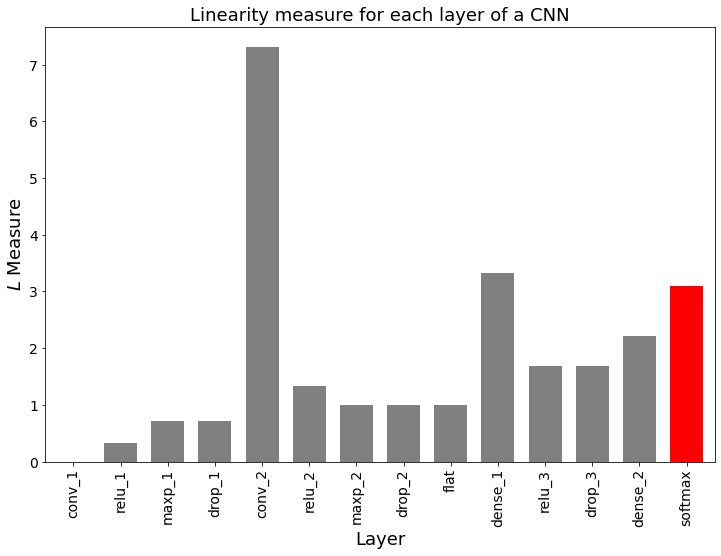

In [ ]:
colors = ['gray' for l in S[:-1]]
colors.append('r')
ax = S.plot(kind='bar', linewidth=3, figsize=(12, 8), color=colors, width=0.7, fontsize=14)
ax.set_ylabel('$L$ Measure', fontsize=18)
ax.set_xlabel('Layer', fontsize=18)
ax.set_title("Linearity measure for each layer of a CNN", fontsize=18)
plt.show()

### Linearity for Each Class
In a similar way, we can aggregate and quantify the nonlinearity for each class separately. This allows us to understand the degree of complexity required to adequately capture each class.

In [ ]:
class_groups = {}
yval_max = y_valid.argmax(1)
for i, name in label_map.items():
  idxs_i = np.where(y_valid_names == name)[0]
  class_groups[name] = x_valid[idxs_i]

In [ ]:
def predict_fn(x):
  return cnn.predict(x)

lins_classes = {}
for name, xdata in class_groups.items():
  cg = np.random.permutation(xdata)[:200]
  lin = linearity_measure(predict_fn, cg, feature_range=feature_range, agg='global', model_type='classifier', nb_samples=20)
  lins_classes[name] = lin 

In [ ]:
df = pd.DataFrame(lins_classes)

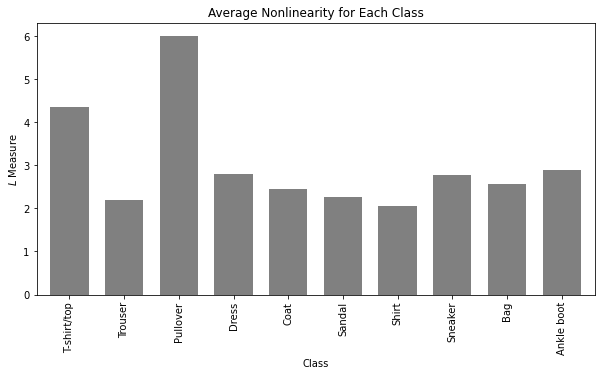

In [ ]:
ax = df.mean().plot(kind='bar', linewidth=3, figsize=(10, 5), color='gray', width=0.7)
ax.set_ylabel("$L$ Measure")
ax.set_xlabel("Class")
ax.set_title("Average Nonlinearity for Each Class")
plt.show()

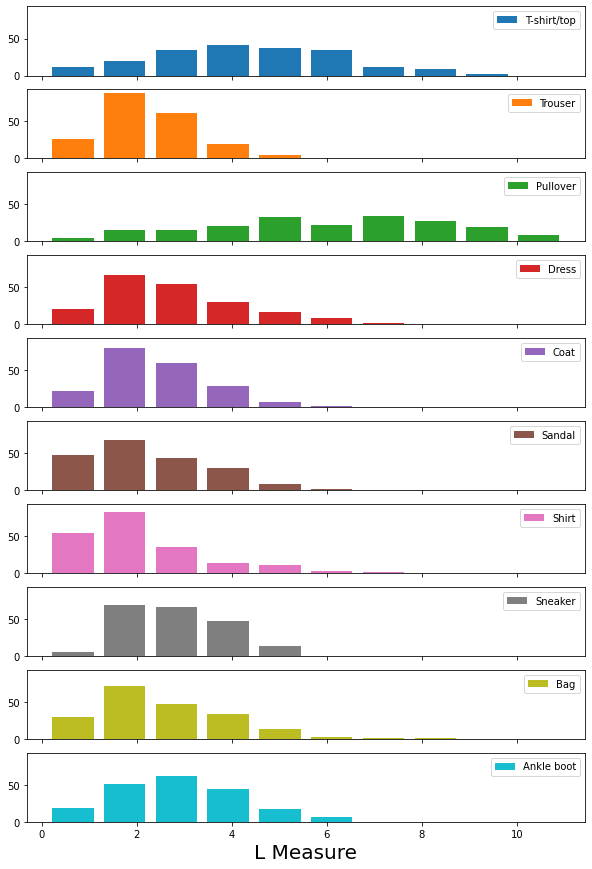

In [ ]:
ax2 = df.plot(kind='hist', subplots=True, bins=10, rwidth=0.8, sharey=True, figsize=(10, 15))
for a in ax2:
  a.set_xlabel("L Measure", fontsize=20)
  a.set_ylabel('', rotation=True, fontsize=10)

plt.show()

## Local Interpretability
* Contrastive Explanation Method
  * Perturbation-based approach which finds the minimal change needed to influence the prediction
  * Will possibly need an autoencoder model as well

### Integrated Gradients
Gradient-based attribution allows us to visualize the key pieces of information that the model uses when predicting on an individual instance. We'll use this method to explore the association between input features and predictions for our Fashion-MNIST model.

In [ ]:
from alibi.explainers.integrated_gradients import IntegratedGradients

In [ ]:
n_steps = 100
method = "gausslegendre"
ig = IntegratedGradients(cnn, n_steps=n_steps,  method=method)

Calculate attributions for the first few images in the validation set

In [ ]:
n_samples = 50

X_sample = x_valid[:n_samples]
predictions = valid_pred[:n_samples].argmax(1)
predictions_names=valid_pred_names[:n_samples]
actuals_names = y_valid_names[:n_samples]

explanation = ig.explain(X_sample, baselines=None, target=predictions)

In [ ]:
explanation.meta

{'explanations': ['local'],
 'name': 'IntegratedGradients',
 'params': {'internal_batch_size': 100,
  'layer': 0,
  'method': 'gausslegendre',
  'n_steps': 100},
 'type': ['whitebox']}

In [ ]:
explanation.data.keys()

dict_keys(['attributions', 'X', 'baselines', 'predictions', 'deltas', 'target'])

In [ ]:
attrs = explanation.attributions[0]

Visualize the gradient attributions. Let's start with a few we got right.

In [ ]:
np.random.seed(652)
correct_ids = np.random.choice(np.where(predictions_names == actuals_names)[0], 3, replace=False).tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


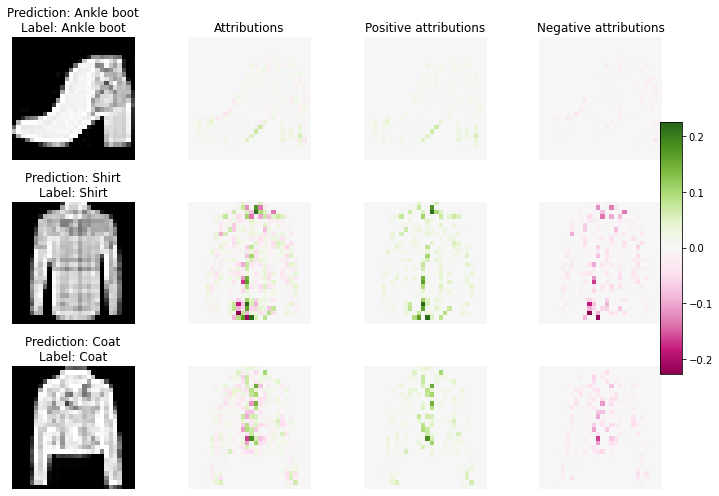

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
cmap_bound = np.abs(attrs[correct_ids]).max()

for row, image_id in enumerate(correct_ids):
    # original images
    ax[row, 0].imshow(X_sample[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions_names[image_id]}\nLabel: {actuals_names[image_id]}')

    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]))
fig.tight_layout()
fig.show()

This is interesting! We can see that the model highlights the first coat's hood and chest, the sneaker's tongue and upper, and the second coat's zipper.

Now we can see a few where our model predicts incorrectly. This can be helpful in diagnosing model errors and guiding future improvement.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


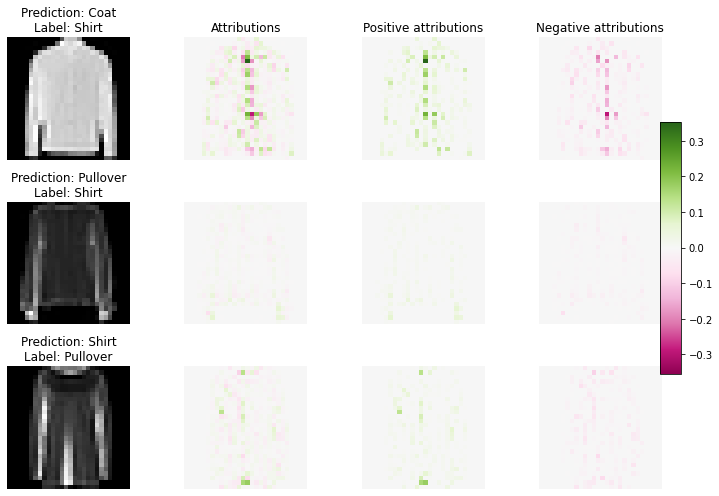

In [ ]:
np.random.seed(763)
wrong_ids = np.random.choice(np.where(predictions_names != actuals_names)[0], 3, replace=False).tolist()

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
cmap_bound = np.abs(attrs[wrong_ids]).max()

for row, image_id in enumerate(wrong_ids):
    # original images
    ax[row, 0].imshow(X_sample[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions_names[image_id]}\nLabel: {actuals_names[image_id]}')

    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]))
fig.tight_layout()
fig.show()

Here, we can see that there are strongly positive regions that contribute to the incorrect predictions. For the first image, the model keys on the buttons and predicts coat instead of shirt. The second image is a sandal, but the intensity at the heel seems to influence the model toward predicting bag. 

The third image shows that the model focuses on the hem and zipper, but the negative attributions for the zipper were not strong enough to move it toward a coat.

### Anchors

Anchoring is a method that, similarly to integrated gradients, highlights the most informative features in an image.

In [ ]:
from alibi.explainers import AnchorImage

We need to define a few things to prepare for image anchoring. First, we need a method of generating rectangular superpixels for a given image. This function is taken from the Alibi documentation - however, built-in methods exist.

In [ ]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

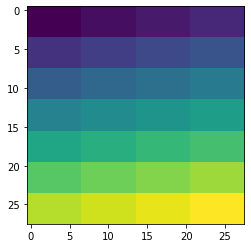

In [ ]:
segments = superpixel(x_train[0])
plt.imshow(segments)

We also need a prediction function.

In [ ]:
def predict_fn(x):
  return cnn.predict(x)

In [ ]:
image_shape = x_valid[0].shape
explainer = AnchorImage(predict_fn, image_shape=image_shape, 
                        segmentation_fn=superpixel)

Let's start with one we got right - we'll sample an image and highlight the anchor region.

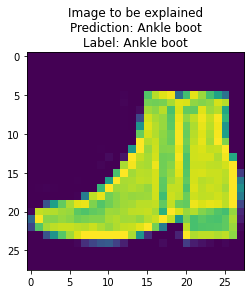

In [ ]:
np.random.seed(751)
idx = np.random.choice(np.where(y_valid_names == valid_pred_names)[0])
image = x_valid[idx]
plt.imshow(image.squeeze())
plt.title("Image to be explained\nPrediction: {}\nLabel: {}".format(
    valid_pred_names[idx],
    y_valid_names[idx]
))
plt.show()

In [ ]:
explanation = explainer.explain(image, 
                                threshold=0.9,
                                p_sample=0.5, 
                                seed=0)

plt.imshow(explanation.anchor.squeeze());

ValueError: ignored

We can see that the intensity of the sandal's strap is the anchor point for predicting it correctly.

And now we do the same for an image we got wrong.

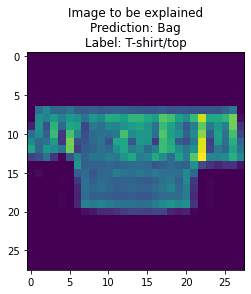

In [ ]:
np.random.seed(221)
idx = np.random.choice(np.where(y_valid_names != valid_pred_names)[0])
image = x_valid[idx]
plt.imshow(image.squeeze())
plt.title("Image to be explained\nPrediction: {}\nLabel: {}".format(
    valid_pred_names[idx],
    y_valid_names[idx]
))
plt.show()

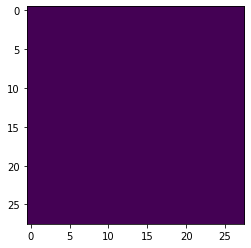

In [ ]:
explanation = explainer.explain(image, 
                                threshold=0.9,
                                p_sample=0.5, 
                                seed=0)

plt.imshow(explanation.anchor.squeeze());

From this, we can see that the shoulder of this garment is the region fooling the model into classifying it as a t-shirt instead of a shirt. Perhaps another model could do a better job of identifying the differences between t-shirts and shirts, or perhaps we need more training examples to reinforce these classes. Alternatively, this could help us realize that there may not be a meaningful difference in these classes.



### Counterfactuals

Counterfactuals help us understand model behavior by distorting an input *just enough* to change the prediction. More specifically, this method finds the minimal amount of distortion required to make the model arbitrarily confident in a different prediction, which can help us understand the model's representation of the problem.

In [ ]:
from alibi.explainers import CounterFactual

The counterfactual method is not compatible with TensorFlow's eager execution.

In [ ]:
cnn.save_weights("tmp_cnn_weights.h5")

In [ ]:
# tf.config.run_functions_eagerly(False)
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
non_eager = model()
non_eager.load_weights("tmp_cnn_weights.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Let's start by taking an example image from the validation set.

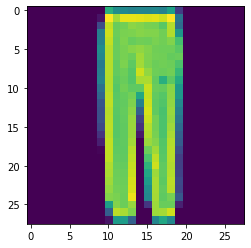

In [ ]:
np.random.seed(98101)
idx = np.random.randint(0, x_valid.shape[0])
example_img = np.expand_dims(x_valid[idx], 0)

plt.imshow(example_img.squeeze());

Now let's specify the counterfactual explainer.

In [ ]:
shape = (1,) + x_valid.shape[1:]
target_proba = 1.0
tol = 0.01 # we want to generate a counterfactual with P(class) > 0.99
target_class = 'other' # any other class
max_iter = 100
lam_init = 0.2 # penalty term applied to L1 distance
max_lam_steps = 10
lr_init = 0.1 
feature_range = x_train.min(), x_train.max()

In [ ]:
%%time
cf = CounterFactual(non_eager, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, 
                    lam_init=lam_init, max_lam_steps=max_lam_steps,
                    learning_rate_init=lr_init,
                    feature_range=feature_range)

explanation = cf.explain(example_img)


CPU times: user 7.09 s, sys: 864 ms, total: 7.95 s
Wall time: 6.77 s


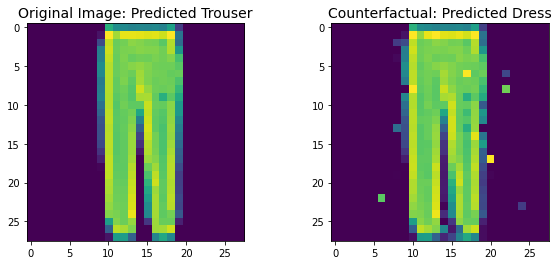

In [ ]:
pred_class = explanation.cf['class']
pred_name = label_map[pred_class]
original_pred_name = valid_pred_names[idx]

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].imshow(example_img.squeeze())
ax[0].set_title(f"Original Image: Predicted {original_pred_name}", fontsize=14)

ax[1].imshow(explanation.cf['X'].squeeze())
ax[1].set_title(f"Counterfactual: Predicted {pred_name}", fontsize=14)

plt.show()

This is an interesting one! We can see that we can trick the model into classifying this pair of trousers as a dress simply by adding a diagonal line of pixels toward the bottom of the garment. 

These counterfactuals can help us identify brittle decision thresholds for our models - for example, we did not augment any of the training images, and exploring these counterfactuals help show us that the model is exploiting the common regions of the photo rather than the features of the captured objects.

### Contrastive Explanation Method
In a similar vein as counterfactuals, the contrastive explanation method (CEM) attempts to explain the *minimally necessary* features that influence a prediction. It does this in two ways: pertinent positives and pertinent negatives - the former highlights the pixels that must be present in order to provide the specified prediction, and the latter highlights those that must be omitted. 

We'll use an autoencoder to generate examples for CEM.

In [ ]:
from alibi.explainers import CEM
from tensorflow.keras.layers import UpSampling2D

In [ ]:
def ae_model():
  x_in = Input(shape=(28, 28, 1))
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
  encoder = Model(x_in, encoded)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

  autoencoder = Model(x_in, decoded)
  autoencoder.compile(optimizer='adam', loss='mse')

  return autoencoder, encoder

In [ ]:
ae, enc = ae_model()
ae.summary()
ae.fit(x_train, x_train, 
       batch_size=128, epochs=4,
       validation_data=(x_valid, x_valid),
       verbose=0)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0   

Let's test it out.

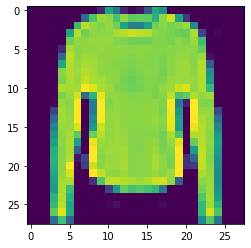

In [ ]:
np.random.seed(286)
idx = np.random.randint(0, x_valid.shape[0])
example_img = np.expand_dims(x_valid[idx], 0)

plt.imshow(example_img.squeeze());

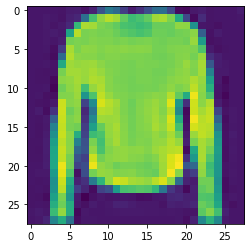

In [ ]:
plt.imshow(ae.predict(example_img).squeeze())

That seems good enough for our purpose. Let's see whether the prediction changes.

In [ ]:
print("Original:", valid_pred_names[idx])
print("New:", label_map[non_eager.predict(ae.predict(example_img)).argmax()])

Original: Pullover
New: Pullover


Nope - onward to generating contrastive explanations. Let's start with pertinent negatives.

In [ ]:
mode = 'PN'
shape = (1, ) + x_valid.shape[1:]
kappa = 0. 
beta = 0.1 # weight of L1 loss term
gamma = 10 # weight of optional autoencoder loss term
c_init = 10 # initial weight of the loss term encouraging to predict a different class (PN) or same class (PP)
c_steps = 10
max_iterations = 500
clip = (-1000, 1000)
lr = 1e-3
no_info_value = -1.

In [ ]:
cem = CEM(non_eager, mode, shape, kappa=kappa, beta=beta, 
          feature_range=feature_range, 
          gamma=gamma, ae_model=ae, 
          max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, 
          clip=clip, no_info_val=no_info_value)

explanation = cem.explain(example_img)

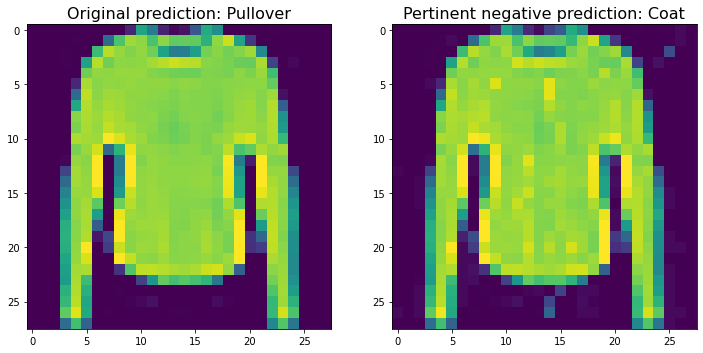

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].imshow(example_img.squeeze())
ax[0].set_title(f"Original prediction: {valid_pred_names[idx]}", fontsize=16)

ax[1].imshow(explanation.PN.squeeze())
ax[1].set_title(f"Pertinent negative prediction: {label_map[explanation.PN_pred]}", fontsize=16)
plt.show()

It may be hard to see exactly the features that were added in order to influence the prediction, so we can highlight them through a direct subtraction.

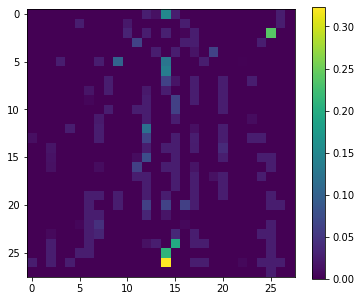

In [ ]:
plt.figure(figsize=(6,5))
plt.imshow(explanation.PN.squeeze() - example_img.squeeze())
plt.colorbar()
plt.show()

As a reminder, the pertinent negative is showing the pixels that must be omitted for a given prediction to hold (or added to make the prediction change). In this case, slight changes in pixel intensity around the sleeve were able to change the prediction from pullover to coat.

Let's try a pertinent positive:

In [ ]:
cem = CEM(non_eager, 'PP', shape, kappa=kappa, beta=beta, 
          feature_range=feature_range, 
          gamma=gamma, ae_model=ae, 
          max_iterations=max_iterations, 
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, 
          clip=clip, no_info_val=no_info_value)

explanation = cem.explain(example_img)

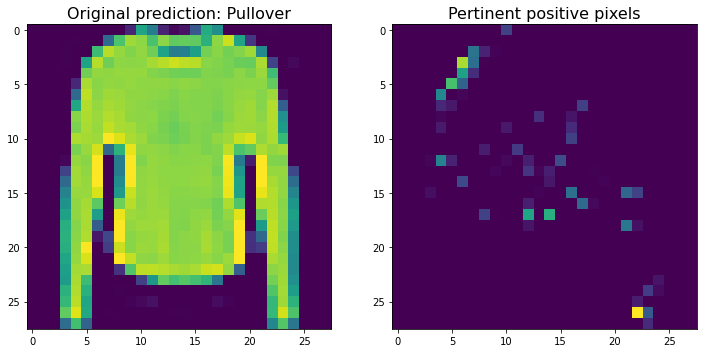

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].imshow(example_img.squeeze())
ax[0].set_title(f"Original prediction: {valid_pred_names[idx]}", fontsize=16)

ax[1].imshow(explanation.PP.squeeze())
ax[1].set_title("Pertinent positive pixels", fontsize=16)
plt.show()

This seems to show us that the lower part of the of the garment is all that's needed to make the model classify it as a pullover.

### Counterfactuals Guided by Prototypes
We'll use the autoencoder trained above, along with the encoder-only component.

In [ ]:
from alibi.explainers import CounterFactualProto

In [ ]:
gamma = 100.
theta = 100.
c_init = 1. 
c_steps = 2
max_iterations = 100

In [ ]:
%%time
cf = CounterFactualProto(non_eager, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)

cf.fit(x_train)

CPU times: user 6.51 s, sys: 1.99 s, total: 8.5 s
Wall time: 7.12 s


In [ ]:
%%time
explanation = cf.explain(example_img)

CPU times: user 2.08 s, sys: 296 ms, total: 2.37 s
Wall time: 1.98 s


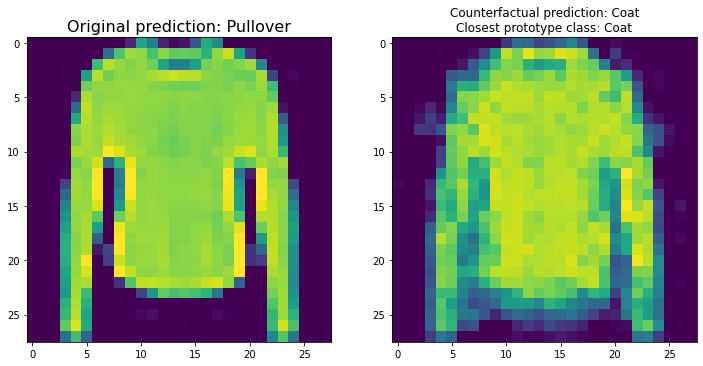

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].imshow(example_img.squeeze())
ax[0].set_title(f"Original prediction: {valid_pred_names[idx]}", fontsize=16)

ax[1].imshow(explanation.cf['X'].squeeze())
ax[1].set_title('Counterfactual prediction: {}\nClosest prototype class: {}'.format(
    label_map[explanation.cf['class']], 
    label_map[explanation.id_proto],
))
plt.show()

This is helpful to highlight the decision behavior of the model - we can see that the distortion/blur applied to the outline of the shirt changed the prediction from pullover to shirt.

This method can be tweaked by changing/removing the penalty terms for both the classifier loss and the autoencoder loss.